In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#!pip install gdown
#!pip install spacy
!python -m spacy download it_core_news_sm

from unicodedata import normalize
import torchtext
import spacy
from torchtext.data import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
import torch
from torchtext.vocab import Vocab, vocab
from torch import nn
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

Let's get the datasets

In [ ]:
!gdown --id "1YUeBQkT3ZFBCKxRt5EzfI1phTDePWXRN" #Readme.txt
!gdown --id "1uNuJ-l7GErR8COmEYv-TUlShdbb9Yl5C" #test-news-taskA.jsonl
!gdown --id "1YLmo82m-oLek-Qh-ncCMnpyl-3V5Tog8" #test-tweets-taskA.jsonl
!gdown --id "1l8wRao-V5Eg6U0-ZR837f5cxvydHdNaQ" #train-taskA.jsonl
!ls

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YUeBQkT3ZFBCKxRt5EzfI1phTDePWXRN
To: /content/Readme.txt
100% 510/510 [00:00<00:00, 2.15MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uNuJ-l7GErR8COmEYv-TUlShdbb9Yl5C
To: /content/test-news-taskA.jsonl
100% 71.3k/71.3k [00:00<00:00, 56.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https:/

In [ ]:
#Some analysis
"""!cat "train-taskA.jsonl" | grep '"label": 0' | head -5
!echo "NUMBER OF SAMPLES"
!cat "train-taskA.jsonl" | grep -c ''
!echo "NUMBER OF SAMPLES USING THE STANDARD LABELS"
!cat "train-taskA.jsonl" | grep -c '"neutrale", "odio"'
!echo "TRAIN SET - LABEL 0"
!cat "train-taskA.jsonl" | grep -c '"label": 0'
!echo "TRAIN SET - LABEL 1"
!cat "train-taskA.jsonl" | grep -c '"label": 1'
!echo "TEST SET TWEETS - LABEL 0"
!cat "test-tweets-taskA.jsonl" | grep -c '"label": 0'
!echo "TEST SET TWEETS - LABEL 1"
!cat "test-tweets-taskA.jsonl" | grep -c '"label": 1'
!echo "TEST SET NEWS - LABEL 0"
!cat "test-news-taskA.jsonl" | grep -c '"label": 0'
!echo "TEST SET NEWS - LABEL 1"
!cat "test-news-taskA.jsonl" | grep -c '"label": 1'"""
#4073/2766 = 1,47

'!cat "train-taskA.jsonl" | grep \'"label": 0\' | head -5\n!echo "NUMBER OF SAMPLES"\n!cat "train-taskA.jsonl" | grep -c \'\'\n!echo "NUMBER OF SAMPLES USING THE STANDARD LABELS"\n!cat "train-taskA.jsonl" | grep -c \'"neutrale", "odio"\'\n!echo "TRAIN SET - LABEL 0"\n!cat "train-taskA.jsonl" | grep -c \'"label": 0\'\n!echo "TRAIN SET - LABEL 1"\n!cat "train-taskA.jsonl" | grep -c \'"label": 1\'\n!echo "TEST SET TWEETS - LABEL 0"\n!cat "test-tweets-taskA.jsonl" | grep -c \'"label": 0\'\n!echo "TEST SET TWEETS - LABEL 1"\n!cat "test-tweets-taskA.jsonl" | grep -c \'"label": 1\'\n!echo "TEST SET NEWS - LABEL 0"\n!cat "test-news-taskA.jsonl" | grep -c \'"label": 0\'\n!echo "TEST SET NEWS - LABEL 1"\n!cat "test-news-taskA.jsonl" | grep -c \'"label": 1\''

Let's define training and validation sets

In [ ]:
main_samples_file = open("train-taskA.jsonl","r")
main_samples = main_samples_file.readlines()
random.Random(17).shuffle(main_samples)
validation_samples = main_samples[:680]
training_samples = main_samples[680:]
training_file = open("training_set.jsonl","w")
validation_file = open("validation_set.jsonl","w")
for sample in training_samples:
  training_file.write(sample)
for sample in validation_samples:
  validation_file.write(sample)
training_file.close()
validation_file.close()
main_samples_file.close()

train_path = "training_set.jsonl"
validation_path = "validation_set.jsonl"
test1_path = "test-tweets-taskA.jsonl"
test2_path = "test-news-taskA.jsonl"

#Analysis to check if we like the split
"""!echo "TRAIN SET - LABEL 0"
!cat "training_set.jsonl" | grep -c '"label": 0'
!echo "TRAIN SET - LABEL 1"
!cat "training_set.jsonl" | grep -c '"label": 1'
!echo "VALIDATION SET - LABEL 0"
!cat "validation_set.jsonl" | grep -c '"label": 0'
!echo "VALIDATION SET - LABEL 1"
!cat "validation_set.jsonl" | grep -c '"label": 1'"""
#3660:2499 = 1,46
#413:267 = 1,55

'!echo "TRAIN SET - LABEL 0"\n!cat "training_set.jsonl" | grep -c \'"label": 0\'\n!echo "TRAIN SET - LABEL 1"\n!cat "training_set.jsonl" | grep -c \'"label": 1\'\n!echo "VALIDATION SET - LABEL 0"\n!cat "validation_set.jsonl" | grep -c \'"label": 0\'\n!echo "VALIDATION SET - LABEL 1"\n!cat "validation_set.jsonl" | grep -c \'"label": 1\''

In [ ]:
"""import matplotlib.pyplot as plt
import json
def plot_labels_distribution(path):
  f = open(path, 'r')
  dataset = f.readlines()
  counter_0 = 0
  counter_1 = 0
  for s in dataset:
    sample = json.loads(s)
    if sample['label'] == 0:
      counter_0 += 1
    elif sample['label'] == 1:
      counter_1 += 1

  labels = ['Neutral (' + str(counter_0) + ')', 'Hate (' + str(counter_1) + ')']
  values = [counter_0, counter_1]

  fig = plt.figure(figsize = (10, 5))
  plt.bar(labels, values, color ='maroon')

  plt.xlabel("Label")
  plt.ylabel("No. of samples")
  plt.title("News test set")
  plt.show()

plot_labels_distribution(test2_path)"""

'import matplotlib.pyplot as plt\nimport json\ndef plot_labels_distribution(path):\n  f = open(path, \'r\')\n  dataset = f.readlines()\n  counter_0 = 0\n  counter_1 = 0\n  for s in dataset:\n    sample = json.loads(s)\n    if sample[\'label\'] == 0:\n      counter_0 += 1\n    elif sample[\'label\'] == 1:\n      counter_1 += 1\n\n  labels = [\'Neutral (\' + str(counter_0) + \')\', \'Hate (\' + str(counter_1) + \')\']\n  values = [counter_0, counter_1]\n\n  fig = plt.figure(figsize = (10, 5))\n  plt.bar(labels, values, color =\'maroon\')\n\n  plt.xlabel("Label")\n  plt.ylabel("No. of samples")\n  plt.title("News test set")\n  plt.show()\n\nplot_labels_distribution(test2_path)'

Let's define the classes we need.

In [ ]:
class TokenizedDataset(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 1028,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        # Get an italian tokenizer
        tokenizer = get_tokenizer("spacy", language="it_core_news_sm")

        # Clean samples
        self.samples = []
        with open(input_file, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                line = sample["text"]
                # Remove useless elements
                line = line.replace("#", "")
                line = line.replace("@user", "")
                line = line.replace("URL", "")
                line = line.replace("\\", "")

                # Keep the letters codified in unicode
                line = line.replace("\u00e8","è")
                line = line.replace("\u00e9","é")
                line = line.replace("\u00f2","ò")
                line = line.replace("\u00f9","ù")
                line = line.replace("\u00ec","ì")
                line = line.replace("\u00e0","à")

                line = line.replace("\u00c8","È")
                line = line.replace("\u00c9","É")
                line = line.replace("\u00d2","Ò")
                line = line.replace("\u00d9","Ù")
                line = line.replace("\u00cc","Ì")
                line = line.replace("\u00c0","À")

                line = line.replace("\u0021","!")
                line = line.replace("\u003f","?")

                # Discard all the other unicode characters (e.g. emojis)
                line = normalize('NFKD', line).encode('ascii','ignore').decode("utf")

                #Clean vocabulary from (supposedly) unrelevant words
                words_to_ignore = ["-", "'"]
                """words_to_ignore = words_to_ignore + ["che", "e", "o", "si", ",", ".", ":"]
                words_to_ignore = words_to_ignore + ["di", "a", "da", "in", "con", "su", "per", "tra", "fra"]
                words_to_ignore = words_to_ignore + ["il", "lo", "la", "i", "gli", "le", "l'"]
                words_to_ignore = words_to_ignore + ["dello", "della", "del", "degli", "dei" "delle", "dell'"]
                words_to_ignore = words_to_ignore + ["allo", "alla", "al", "agli", "alle", "ai", "all' "]
                words_to_ignore = words_to_ignore + ["dallo", "dalla", "dal", "dai", "dalle", "dall'"]
                words_to_ignore = words_to_ignore + ["nella", "nel", "negli", "nelle"]
                words_to_ignore = words_to_ignore + ["sul", "con", "coi"]
                words_to_ignore = words_to_ignore + ["uno", "una", "un", "un'"]"""
                upper_case_version = []
                for w in words_to_ignore:
                  upper_case_version.append(w.upper())
                  first_letter_upper_case = w[:1].upper() + w[1:]
                  upper_case_version.append(first_letter_upper_case)
                words_to_ignore = words_to_ignore + upper_case_version

                # the sample dictionary contains the following key: idx, sentence and label (integer)
                sample["tokens"] = tokenizer(line)
                sample["tokens"] = [i for i in sample["tokens"] if i.strip()]
                sample["tokens"] = [i for i in sample["tokens"] if i not in words_to_ignore]
                self.samples.append(sample)

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        # each dictionary represents a sentence with two keys: "input_ids" and "label"
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # Keep track of padding id
        self.padding_id: int | None = None

    def toString(self, mode) -> str:
        res = ""
        if mode == "verbose":
          res += "SAMPLES\n" + self.samples.toString() + "\n"
        res += "INDEXED DATA\n" + str(self.indexed_data) + "\n"
        res += "MAX LENGTH: " + str(self.max_length) + "\n"
        res += "PADDING ID: " + str(self.padding_id)
        return res

    def get_raw_element(self, idx: int) -> dict:
        """Utility function that gets the raw sample corresponding to `idx`."""
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        """Builds a `torchtext.vocab.Vocab` object from data stored in this object."""
        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
        # We build the vocabulary through a dictionary like {token: frequency, ...}
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        # vocabulary(list of tokens) returns a list of values, so get the only one
        vocabulary.set_default_index(vocabulary([unk_token])[0])
        """print("VOCABULARY:\n")
        most_common_words = list(vocab_counter.keys())[:4000]
        for k in most_common_words:
          print(k + ": " + str(vocab_counter[k]))"""
        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        """Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`"""
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                # append the dictionary containing ids of the input tokens and label
                indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Batches together single elements of the dataset.
        This function:
        - converts each sentence made up of single input_ids to a padded tensor,
        - keeps track of the length of each sentence through `sequence_lengths`
        - builds a `labels` tensor storing the label for each sentence

        Args:
            raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.

        Returns:
            A tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
        """
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

In [ ]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bidirectional: bool,
        scaling_factor: int, #for reducing the input layer size
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim= hidden_dim // scaling_factor ,
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )

        # Feel free to modify and change any hyperparameters or architectural details

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size= hidden_dim // scaling_factor ,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=bidirectional,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padding tokens.
        # An alternative to packing sequences is using masking.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H], where the 2 is because we are using BiLSTMs instead of LSTMs.
        # cell_state has size [2 * num_layers, B, C] where C is the cell dimension of the internal LSTMCell.
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
        # layer's is backward) by concatenating forward and backward over dimension 1.
        # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
        # tensor of shape [B, 2 * H]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden) # [B, 2]
        return logits

In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.BCELoss()
        #self.loss_function = nn.CrossEntropyLoss()

        self.log_steps = log_steps
        self.log_level = log_level

        self.best_model: None | BiLSTMModel = None
        self.best_valid_loss: int = 100000

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
            "zero_guessed_zero": 0,
            "zero_guessed_one": 0,
            "one_guessed_zero": 0,
            "one_guessed_one" : 0
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                m = nn.Sigmoid()
                new_predictions = m(predictions).view(predictions.size()[0]).type(torch.FloatTensor)
                new_labels = labels.type(torch.FloatTensor)
                #print("PREDICTIONS: " + str(predictions))
                #print("NEW PREDICTIONS: " + str(new_predictions))
                sample_loss = self.loss_function(new_predictions, new_labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc, zero_guessed_zero, zero_guessed_one, one_guessed_zero, one_guessed_one = self.evaluate(valid_dataloader, "training")

            if valid_loss < self.best_valid_loss:
              self.best_valid_loss = valid_loss
              self.best_model = self.model

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)
            losses["zero_guessed_zero"] += zero_guessed_zero
            losses["zero_guessed_one"] += zero_guessed_one
            losses["one_guessed_zero"] += one_guessed_zero
            losses["one_guessed_one"] += one_guessed_one

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the BiLSTM model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.

        #predictions = torch.argmax(logits, dim=1)
        predictions = torch.round(logits).type(torch.int64)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        # which averaged gives an accuracy of 4/5, i.e. 0.80.
        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader, mode: str) -> tuple[float, float]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over valid_dataloader.
        """
        if mode == "training":
          used_model = self.model
        elif mode == "evaluation" and self.best_model != None:
          used_model = self.best_model
        else:
          print("Generic error")

        valid_loss = 0.0
        valid_acc = 0.0
        one_guessed_one = 0
        one_guessed_zero = 0
        zero_guessed_one = 0
        zero_guessed_zero = 0
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels = batch

                logits = self.model((sequence_lengths, inputs))

                # Same considerations as the training step apply here
                m = nn.Sigmoid()
                new_logits = m(logits).view(logits.size()[0]).type(torch.FloatTensor)
                new_labels = labels.type(torch.FloatTensor)
                sample_loss = self.loss_function(new_logits, new_labels)
                valid_loss += sample_loss.tolist()

                for i in range(len(new_labels)):
                  index = torch.tensor([i])
                  label = torch.index_select(new_labels, 0, index)
                  logit = torch.round(torch.index_select(new_logits, 0, index))
                  #print("LABEL: " + str(label))
                  #print("LOGIT: " + str(logit))
                  if label == 0 and logit == 0:
                    #print("CASE 1")
                    zero_guessed_zero += 1
                  elif label == 0 and logit == 1:
                    #print("CASE 2")
                    zero_guessed_one += 1
                  elif label == 1 and logit == 1:
                    #print("CASE 3")
                    one_guessed_one += 1
                  elif label == 1 and logit == 0:
                    #print("CASE 4")
                    one_guessed_zero += 1

                sample_acc = self._compute_acc(new_logits, new_labels)
                valid_acc += sample_acc

        return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader), zero_guessed_zero, zero_guessed_one, one_guessed_zero, one_guessed_one

"""    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]: #This is never used!
        """"""
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """"""
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.best_model(sequence_lengths, inputs) # [B, 2]
            m = nn.Sigmoid()
            predictions = torch.round(m(logits))
            print("PREDICTIONS: " + str(predictions))
            return logits, predictions"""

'    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]: #This is never used!\n        \n        Args:\n            x: a tensor of indices\n        Returns:\n            A tuple composed of:\n            - the logits of each class, 0 and 1\n            - the prediction for each sample in the batch\n              0 if the sentiment of the sentence is negative, 1 if it is positive.\n        \n        self.model.eval()\n        with torch.no_grad():\n            sequence_lengths, inputs = batch\n            logits = self.best_model(sequence_lengths, inputs) # [B, 2]\n            m = nn.Sigmoid()\n            predictions = torch.round(m(logits))\n            print("PREDICTIONS: " + str(predictions))\n            return logits, predictions'

Inizialize everything we need.

In [ ]:
torch.manual_seed(0) #For shuffle

pad_token, unk_token = "<pad>", "<unk>"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = TokenizedDataset(train_path, device=device)
validation_dataset = TokenizedDataset(validation_path, device=device)
test1_dataset = TokenizedDataset(test1_path, device=device)
test2_dataset = TokenizedDataset(test2_path, device=device)

vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary([pad_token])[0]

train_dataset.set_padding_id(padding_id)
validation_dataset.set_padding_id(padding_id)
test1_dataset.set_padding_id(padding_id)
test2_dataset.set_padding_id(padding_id)

train_dataset.index(vocabulary)
validation_dataset.index(vocabulary)
test1_dataset.index(vocabulary)
test2_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(validation_dataset)}")
print(f"Test1 len: {len(test1_dataset)}")
print(f"Test2 len: {len(test2_dataset)}")

training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False, collate_fn=validation_dataset._collate_fn)
test1_dataloader = DataLoader(test1_dataset, batch_size=64, shuffle=False, collate_fn=test1_dataset._collate_fn)
test2_dataloader = DataLoader(test2_dataset, batch_size=64, shuffle=False, collate_fn=test2_dataset._collate_fn)

Training len: 5479
Validation len: 1360
Test1 len: 1263
Test2 len: 500


Let's define and use a simple random baseline.

In [ ]:
class RandomBaseline():

  def predict(self, dataset):
    l = len(dataset)
    predictions = [random.randint(0, 1) for i in range(l)]
    return predictions

  def compute_accuracy(self, predictions: list, dataset):
    c = 0
    for i in range(len(predictions)):
      if predictions[i] == dataset[i]['label']:
        c += 1
    return c/len(predictions)

In [ ]:
#Baseline evaluation
random.seed(17)

baseline = RandomBaseline()
validation_predictions = baseline.predict(validation_dataset)
validation_accuracy = baseline.compute_accuracy(validation_predictions, validation_dataset)
print("Validation accuracy: " + str(validation_accuracy))

test1_predictions = baseline.predict(test1_dataset)
test1_accuracy = baseline.compute_accuracy(test1_predictions, test1_dataset)
print("Test1 accuracy: " + str(test1_accuracy))

test2_predictions = baseline.predict(test2_dataset)
test2_accuracy = baseline.compute_accuracy(test2_predictions, test2_dataset)
print("Test2 accuracy: " + str(test2_accuracy))

Validation accuracy: 0.5205882352941177
Test1 accuracy: 0.5154394299287411
Test2 accuracy: 0.478


And now let's use our model.

In [ ]:
torch.manual_seed(0)

sentiment_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=16,
    bilstm_layers=2,
    bidirectional=False,
    scaling_factor=2,
    bilstm_dropout=0.3,
    num_classes=1,
    padding_id=padding_id,
    device=device
)
#Batch size is 64 for all the datasets

trainer = Trainer(
    model=sentiment_tagger,
    optimizer=torch.optim.Adam(sentiment_tagger.parameters(), lr=0.0001, weight_decay=0.001),
    log_steps=100
)

losses = trainer.train(training_dataloader, validation_dataloader, epochs=200) #Provare 100, 200 e 125

Training ...
 Epoch  1
	[E:  1] train loss = 0.6860
  [E:  1] valid loss = 0.6841, valid acc = 0.6009
 Epoch  2
	[E:  2] train loss = 0.6828
  [E:  2] valid loss = 0.6809, valid acc = 0.6009
 Epoch  3
	[E:  3] train loss = 0.6800
  [E:  3] valid loss = 0.6783, valid acc = 0.6009
 Epoch  4
	[E:  4] train loss = 0.6778
  [E:  4] valid loss = 0.6760, valid acc = 0.6009
 Epoch  5
	[E:  5] train loss = 0.6762
  [E:  5] valid loss = 0.6744, valid acc = 0.6009
 Epoch  6
	[E:  6] train loss = 0.6749
  [E:  6] valid loss = 0.6732, valid acc = 0.6009
 Epoch  7
	[E:  7] train loss = 0.6740
  [E:  7] valid loss = 0.6723, valid acc = 0.6009
 Epoch  8
	[E:  8] train loss = 0.6733
  [E:  8] valid loss = 0.6716, valid acc = 0.6009
 Epoch  9
	[E:  9] train loss = 0.6725
  [E:  9] valid loss = 0.6710, valid acc = 0.6009
 Epoch 10
	[E: 10] train loss = 0.6719
  [E: 10] valid loss = 0.6705, valid acc = 0.6009
 Epoch 11
	[E: 11] train loss = 0.6718
  [E: 11] valid loss = 0.6699, valid acc = 0.6009
 Epoch 1

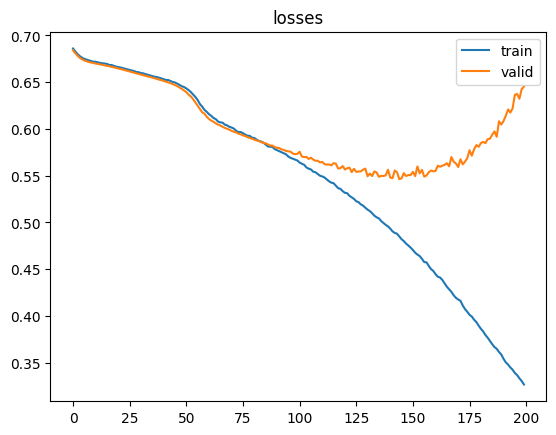

In [ ]:
import matplotlib.pyplot as plt

plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

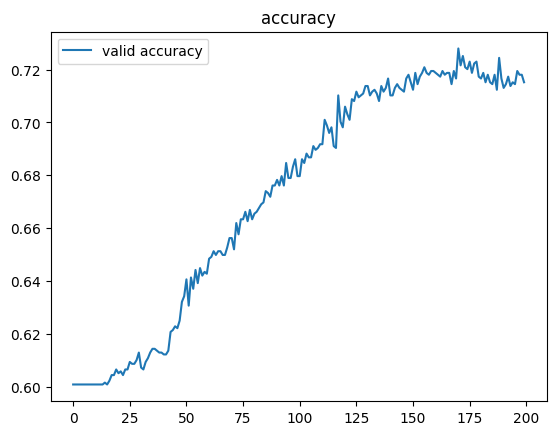

In [ ]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc, zero_guessed_zero, zero_guessed_one, one_guessed_zero, one_guessed_one = trainer.evaluate(validation_dataloader, "evaluation")
print(f"Validation loss {test_loss}, Validation accuracy: {test_acc}")
print("zero_guessed_zero: " + str(zero_guessed_zero))
print("zero_guessed_one: " + str(zero_guessed_one))
print("one_guessed_zero: " + str(one_guessed_zero))
print("one_guessed_one: " + str(one_guessed_one))

Test loss 0.6453662433407523, Test accuracy: 0.7151988636363636
zero_guessed_zero: 583
zero_guessed_one: 227
one_guessed_zero: 156
one_guessed_one: 394


In [ ]:
test_loss, test_acc, zero_guessed_zero, zero_guessed_one, one_guessed_zero, one_guessed_one = trainer.evaluate(test1_dataloader, "evaluation")
print(f"Test1 loss {test_loss}, Test1 accuracy: {test_acc}")
print("zero_guessed_zero: " + str(zero_guessed_zero))
print("zero_guessed_one: " + str(zero_guessed_one))
print("one_guessed_zero: " + str(one_guessed_zero))
print("one_guessed_one: " + str(one_guessed_one))

Test loss 0.7804873391985894, Test accuracy: 0.6505817830562591
zero_guessed_zero: 339
zero_guessed_one: 302
one_guessed_zero: 142
one_guessed_one: 480


In [ ]:
test_loss, test_acc, zero_guessed_zero, zero_guessed_one, one_guessed_zero, one_guessed_one = trainer.evaluate(test2_dataloader, "evaluation")
print(f"Test2 loss {test_loss}, Test2 accuracy: {test_acc}")
print("zero_guessed_zero: " + str(zero_guessed_zero))
print("zero_guessed_one: " + str(zero_guessed_one))
print("one_guessed_zero: " + str(one_guessed_zero))
print("one_guessed_one: " + str(one_guessed_one))

Test loss 0.8920022435486317, Test accuracy: 0.6631610542535782
zero_guessed_zero: 293
zero_guessed_one: 26
one_guessed_zero: 146
one_guessed_one: 35
